#Import libraries and data

In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 97 kB 2.9 MB/s 


In [2]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras.datasets import cifar10
import random
from random import randint
import tensorflow as tf
import numpy as np
import cv2
import random
from tqdm import tqdm
import sys
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import kerastuner as kt
from keras.callbacks import EarlyStopping
import keras
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os
from tensorboard.plugins.hparams import api as hp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
import tensorflow_datasets as tfds

data = tfds.load('cifar10')
train_ds, test_ds = data['train'], data['test']

def standardize_record(record):
  return tf.cast(record['image'], tf.float32) / 255., record['label']

train_ds = train_ds.map(standardize_record).cache().batch(64).shuffle(10000)
test_ds = test_ds.map(standardize_record).cache().batch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteY6QWTH/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteY6QWTH/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


#CNNs

Hyperparmeter tuning with Hyperband

In [5]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [6]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=2,
    overwrite=True)

In [7]:
tuner.search(train_ds,
             validation_data=test_ds,
             epochs=5,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 20 Complete [00h 01m 02s]
val_accuracy: 0.6312000155448914

Best val_accuracy So Far: 0.776199996471405
Total elapsed time: 01h 05m 41s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [8]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
h_model = tuner.hypermodel.build(best_hyperparameters)
h_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 224)       6272      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 224)       896       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 224)       451808    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 224)       896       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 224)       0     

In [9]:
history=h_model.fit(trainX,trainY, epochs=50, validation_split=0.2)

Epoch 1/50
1250/1250 [==============================] - 92s 72ms/step - loss: 1.4971 - accuracy: 0.4518 - val_loss: 1.5175 - val_accuracy: 0.4668
Epoch 2/50
1250/1250 [==============================] - 89s 71ms/step - loss: 1.0385 - accuracy: 0.6312 - val_loss: 1.1492 - val_accuracy: 0.6089
Epoch 3/50
1250/1250 [==============================] - 89s 71ms/step - loss: 0.8103 - accuracy: 0.7180 - val_loss: 1.0457 - val_accuracy: 0.6660
Epoch 4/50
1250/1250 [==============================] - 89s 71ms/step - loss: 0.6585 - accuracy: 0.7731 - val_loss: 0.8971 - val_accuracy: 0.6955
Epoch 5/50
1250/1250 [==============================] - 89s 72ms/step - loss: 0.5548 - accuracy: 0.8118 - val_loss: 0.9920 - val_accuracy: 0.6739
Epoch 6/50
1250/1250 [==============================] - 89s 71ms/step - loss: 0.4640 - accuracy: 0.8415 - val_loss: 0.6256 - val_accuracy: 0.7961
Epoch 7/50
1250/1250 [==============================] - 89s 71ms/step - loss: 0.3944 - accuracy: 0.8652 - val_loss: 0.6641 -

In [10]:
h_eval_dict = h_model.evaluate(testX, testY, return_dict=True)

313/313 [==============================] - 7s 23ms/step - loss: 0.8139 - accuracy: 0.8472


Minimum validation loss: 0.5869055390357971


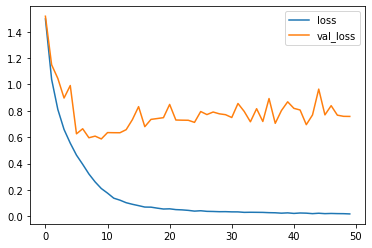

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Maxinmum Validation Accuracy: 0.8589000105857849


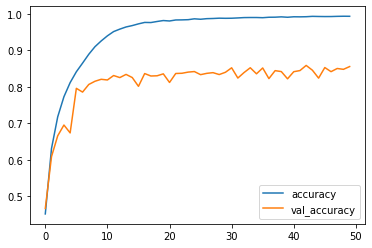

In [12]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Maxinmum Validation Accuracy: {}".format(history_df['val_accuracy'].max()))

Hyper parameter tuning with Bayesian

In [13]:
def build_model(hp):
  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [14]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    overwrite=True)

In [15]:
tuner.search(train_ds,
             validation_data=test_ds,
             epochs=5,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 15 Complete [00h 04m 11s]
val_accuracy: 0.663100004196167

Best val_accuracy So Far: 0.753600001335144
Total elapsed time: 01h 15m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [16]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
h_model = tuner.hypermodel.build(best_hyperparameters)
h_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 160)       4480      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 160)       640       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 160)       230560    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 160)       640       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 160)       0     

In [ ]:
history=h_model.fit(trainX,trainY, epochs=50, validation_split=0.2)

Epoch 1/50
1250/1250 [==============================] - 75s 58ms/step - loss: 1.8137 - accuracy: 0.3738 - val_loss: 1.3258 - val_accuracy: 0.5548
Epoch 2/50
1250/1250 [==============================] - 72s 57ms/step - loss: 1.2965 - accuracy: 0.5652 - val_loss: 1.0875 - val_accuracy: 0.6356
Epoch 3/50
 142/1250 [==>...........................] - ETA: 58s - loss: 1.0665 - accuracy: 0.6450

In [ ]:
h_eval_dict = h_model.evaluate(testX, testY, return_dict=True)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Maxinmum Validation Accuracy: {}".format(history_df['val_accuracy'].max()))

Hyperparam tuning with Bayesian (Resnet)

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
def build_model_resnet(hp):
    
    inputs = Input(shape=(32, 32, 3))
    num_filters = hp.Int('filters_' , 32, 256, step=32)
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    if hp.Choice('pooling_', ['avg', 'max']) == 'max':
      t = tf.keras.layers.MaxPool2D()(t)
    else:
      t = tf.keras.layers.AvgPool2D()(t)
    t= tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(t)
    
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, outputs)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_model_resnet,
    objective='val_accuracy',
    max_trials=5,
    overwrite=True)

In [ ]:
tuner.search(train_ds,
             validation_data=test_ds,
             epochs=3,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [ ]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
h_model = tuner.hypermodel.build(best_hyperparameters)
h_model.summary()

In [ ]:

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)
hparams_callback = hp.KerasCallback(log_dir, {
    'num_relu_units': 512,
    'dropout': 0.2
})

In [ ]:
history=h_model.fit(trainX,trainY, epochs=30, validation_split=0.2,callbacks=[tensorboard_callback, hparams_callback])